# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Raffaele Sindoni Saposhnik

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [6]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 MB 31.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 34.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 33.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.0
    Uninstalling ml_dtypes-0.5.0:
      Successfully uninstalled ml_dtypes-0.5.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [21]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

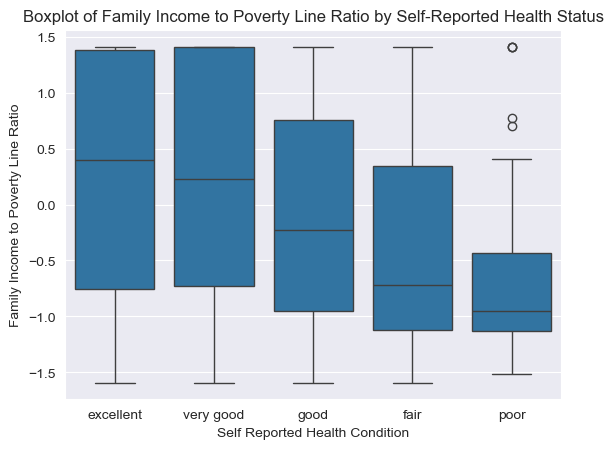

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

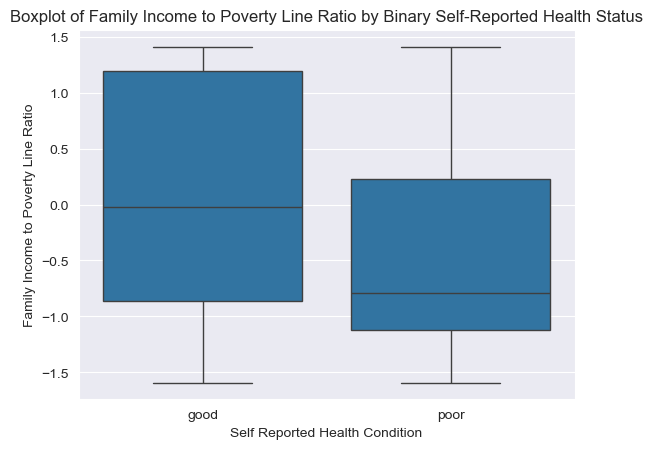

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

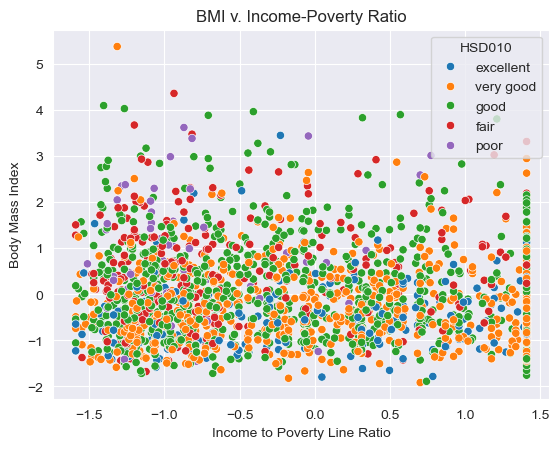

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [8]:
# Import libraries
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(nhanes_scaled)

# Calculate explained variance ratio and cumulative variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Determine number of components to retain 95% of variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1  

# Print results
print(f"Explained variance by each component: {explained_variance_ratio}")
print(f"Cumulative variance explained: {cumulative_variance}")
print(f"Number of components to retain 95% variance: {n_components}")

Explained variance by each component: [1.02019612e-01 7.62301114e-02 4.37119204e-02 2.88217170e-02
 2.35713187e-02 1.90163035e-02 1.81085215e-02 1.65559207e-02
 1.55711604e-02 1.53219695e-02 1.31996369e-02 1.21278889e-02
 1.15793671e-02 1.15598097e-02 1.11000658e-02 1.00458298e-02
 9.43222952e-03 9.32323519e-03 8.80416250e-03 8.69021037e-03
 8.40107425e-03 8.26033116e-03 7.96176231e-03 7.82773616e-03
 7.53779323e-03 7.23657144e-03 7.11080739e-03 6.94057200e-03
 6.79371347e-03 6.45721037e-03 6.39647971e-03 6.31755599e-03
 6.21805295e-03 6.17777322e-03 5.92812176e-03 5.77469797e-03
 5.68546881e-03 5.63024512e-03 5.61692644e-03 5.55578734e-03
 5.49481998e-03 5.43106951e-03 5.31583404e-03 5.27999114e-03
 5.21820240e-03 5.16186157e-03 5.10943993e-03 5.01990417e-03
 4.98593377e-03 4.95576889e-03 4.91154746e-03 4.84287943e-03
 4.82170766e-03 4.75045769e-03 4.72203194e-03 4.63836409e-03
 4.62511957e-03 4.58822666e-03 4.51284868e-03 4.48921812e-03
 4.47073111e-03 4.38718004e-03 4.37625134e-03 4

We chose 145 components because they collectively capture 95% of the total variance in the dataset. This ensures most information in the original variables is preserved while reducing uneccissary dimensionality. This makes the dataset easier to model + interpret without retaining unnecessary noise.

### Barplot of Components

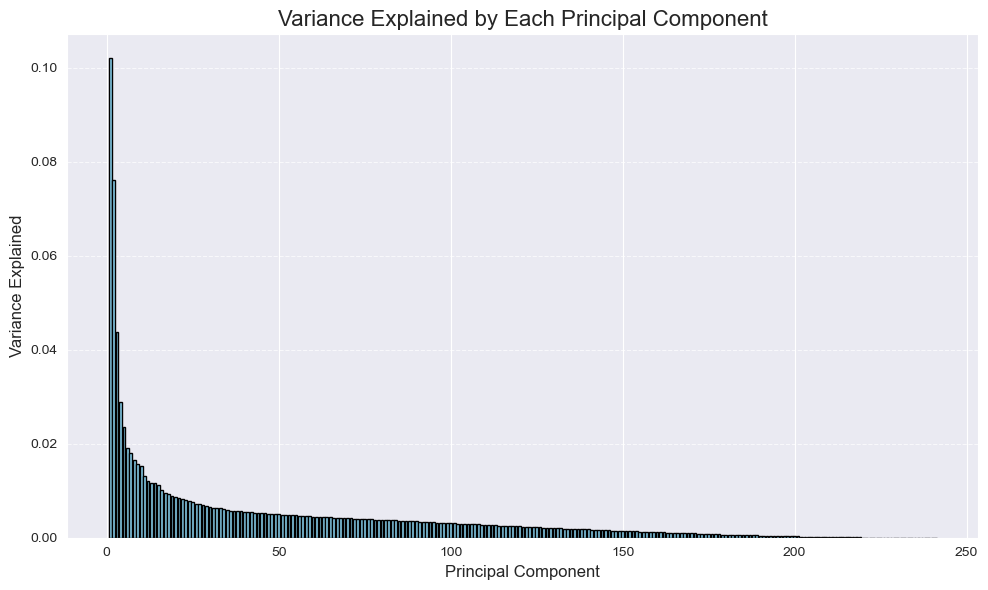

In [9]:
import matplotlib.pyplot as plt

# Barplot of variance explained by each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color="skyblue", edgecolor="black")
plt.title("Variance Explained by Each Principal Component", fontsize=16)
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Variance Explained", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### How many components will you use to fit a supervised learning model?

We could use 30-40 components for the supervised learning model because the scree plot indicates a major drop-off in variance explained after the first ~30-40 components. This suggests that the additional components beyond this range contribute diminishing returns in terms of variance captured. By limiting the number of components, we reduce the dimensionality and complexity of the model, focusing on the most impactful components while avoiding overfitting.

### 2D Scatterplot of the first two components

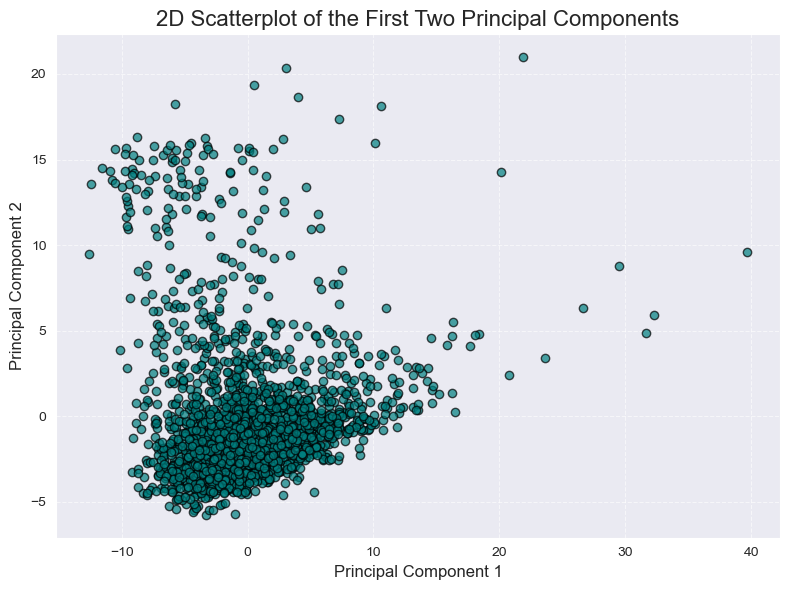

In [10]:
import matplotlib.pyplot as plt

# 2D Scatterplot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, color="teal", edgecolor="black")
plt.title("2D Scatterplot of the First Two Principal Components", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The scatterplot shows the distribution of data points in the space defined by the first two principal components. Most of the points densely clustered near the origin. This shows that there is significant overlap in the primary features contributing to the variance.

The points spread further away from the cluster suggest the presence of outliers; aka other unique feature combinations that contribute distinctively to the variance along these components.

The tightly grouped points might represent people with similar demographics or health indicators. The first two components summarize these patterns, and the cluster shows that many people in the dataset have similar characteristics. Points further away might represent individuals who are very different from the rest—like outliers or unique cases.


## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

K-Means clustering groups data into a pre-specified number of clusters, by minimizing the distance between points and the center of their assigned cluster (called the “centroid”), minimizing the variance within each cluster.

### Cluster nhanes

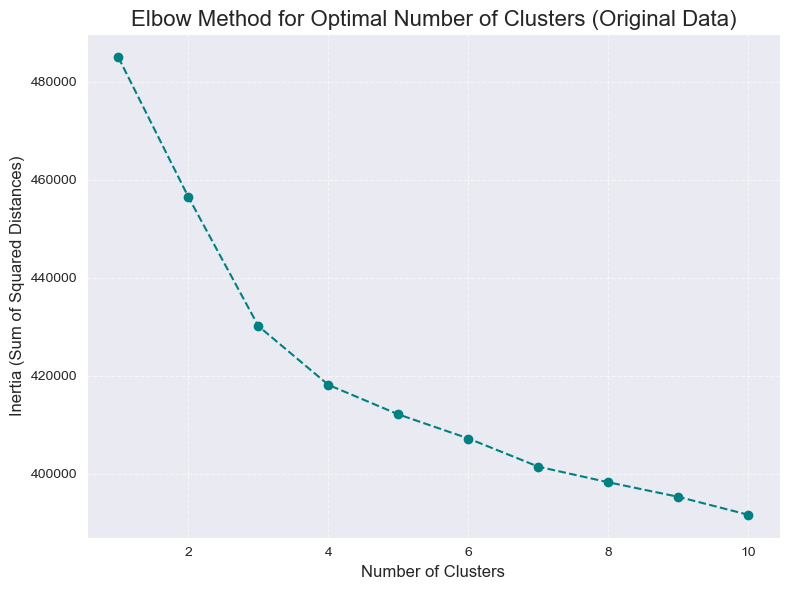

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find the optimal number of clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='teal')
plt.title('Elbow Method for Optimal Number of Clusters (Original Data)', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Based on the elbow, decide the number of clusters (e.g., 3 for this example)
optimal_clusters = 3  # Adjust based on the elbow plot

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(nhanes_scaled)

# Add clusters to the original dataset (optional for further analysis)
#nhanes_data['Cluster'] = clusters

It seems like the elbow is at 3, which means that having three clusters would be helpful for our data, which we can use here. 

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

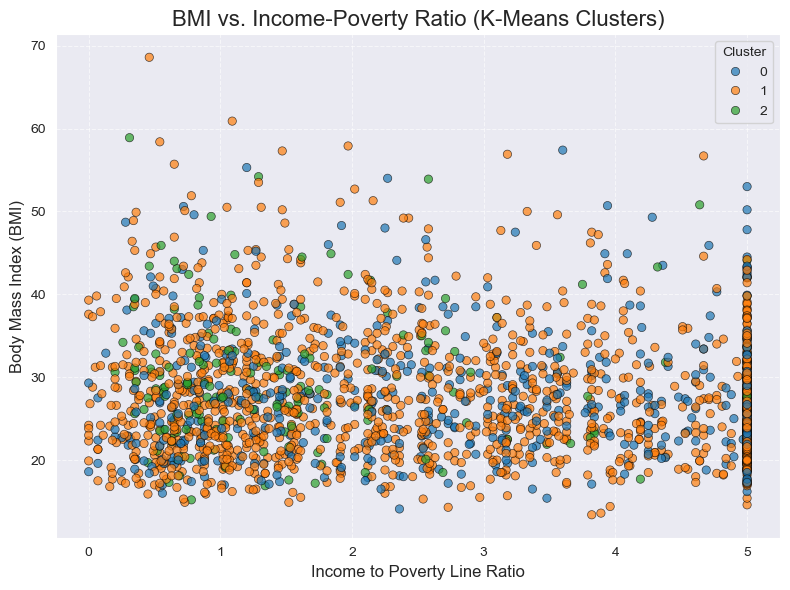

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'BMXBMI' is the column for BMI and 'INDFMPIR' is the column for Income-Poverty Ratio
bmi = nhanes['BMXBMI']
income_ratio = nhanes['INDFMPIR']

# Add the clusters to the dataset for visualization
nhanes['Cluster'] = clusters

# Create the scatterplot with K-Means clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=income_ratio, 
    y=bmi, 
    hue=nhanes['Cluster'], 
    palette='tab10', 
    edgecolor='black', 
    alpha=0.7
)
plt.xlabel("Income to Poverty Line Ratio", fontsize=12)
plt.ylabel("Body Mass Index (BMI)", fontsize=12)
plt.title("BMI vs. Income-Poverty Ratio (K-Means Clusters)", fontsize=16)
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

I'm not sure if I did something wrong here, but it doens't seem like there is a clear way to cluster here? Maybe that tell us that BMI and Income-Poverty Ratio may not be sufficient on their own to separate the data into meaningful groups?

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

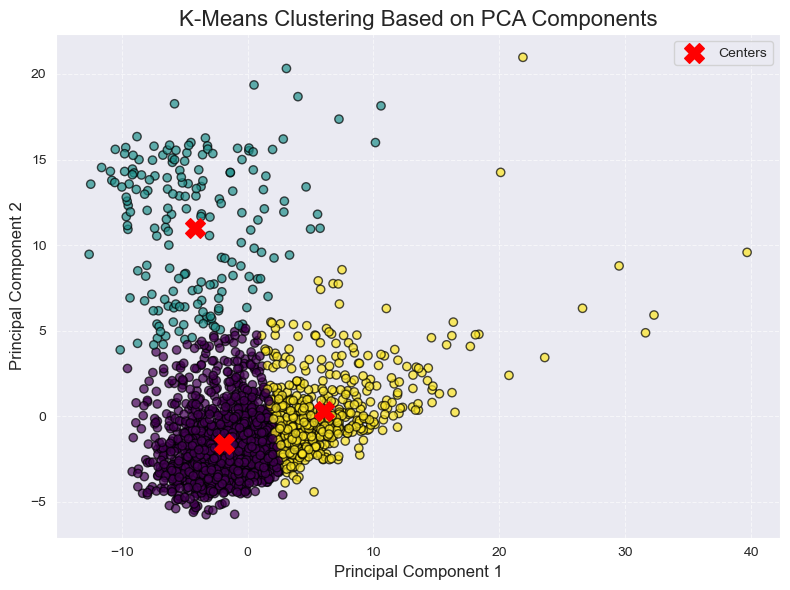

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming you have PCA results stored in `pca_result` from earlier steps
# Replace with your number of clusters (from the Elbow Method or assumption)
optimal_clusters = 3

# Fit K-Means using the first two PCA components
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_result[:, :2])  # Using the first two PCA components

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.7, edgecolor='black')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centers')
plt.title('K-Means Clustering Based on PCA Components', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

If I understand right, The PCA clustering shows a clear separation of data points along the first two principal components, which means the PCA-transformed features capture meaningful patterns in the data, allowing K-Means to define distinct clusters more effectively compared to using raw variables like BMI and Income-Poverty Ratio alone.

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [36]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head

<bound method NDFrame.head of        DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
SEQN                                                                       
73568       0.0  2.034312    0.0  0.324834 -0.393906  1.085853 -0.194202   
73576       0.0  0.261930    0.0 -3.078499  0.568251  0.634362 -0.194202   
73579       0.0  0.728346    0.0  0.324834  1.530407 -1.623092 -0.194202   
73581       0.0 -0.857470    0.0  0.324834  0.480782  1.085853 -0.194202   
73584       0.0  0.495138    0.0  0.324834  0.305844 -1.623092 -0.194202   
...         ...       ...    ...       ...       ...       ...       ...   
83694       0.0  0.261930    0.0  0.324834 -0.481375  1.085853 -0.194202   
83696       0.0  0.495138    0.0  0.324834  1.093063  0.634362 -0.194202   
83704       0.0  0.728346    0.0 -3.078499  0.305844 -0.268620 -0.194202   
83716       0.0 -0.857470    0.0  0.324834 -0.306437  0.182871 -0.194202   
83721       0.0  0.261930    0.0  0.324834 -0.918719 -1.62

In [40]:
# partition data
# -----------

# Define X and y
y = nhanes_scaled['HSD010']  # Replace 'HSD010' with the corrected name
X = nhanes_scaled.drop(['HSD010'], axis=1)

# Partition the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

print(y_train.unique())

[1 2 4 3 5]


In [42]:
import keras
from keras.utils import to_categorical

# Determine the number of classes (ensure it matches the maximum value in y_train + 1)
num_classes = y_train.max() + 1  # Ensure num_classes accounts for the highest class label
print(f"Number of classes: {num_classes}")

# Convert the target variable into binary class matrices
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Verify the shapes
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Number of classes: 6
y_train shape: (1548, 6)
y_test shape: (516, 6)


In [44]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(units=64, input_dim=X_train.shape[1], kernel_initializer='he_normal', activation='relu'))

# Additional hidden layer
model.add(Dense(units=32, kernel_initializer='he_normal', activation='relu'))

# Output layer (units = number of classes for classification)
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    optimizer='adam',                # Adam optimizer for efficiency
    metrics=['accuracy']             # Track accuracy during training
)

# Train the model
history = model.fit(
    X_train, y_train,                 # Training data
    validation_data=(X_test, y_test), # Validation data
    epochs=50,                        # Number of training epochs (adjust as needed)
    batch_size=32,                    # Mini-batch size for training
    verbose=1                         # Show progress during training
)

Epoch 1/50


/Applications/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2376 - loss: 1.8438 - val_accuracy: 0.3953 - val_loss: 1.4782
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.5137 - loss: 1.2656 - val_accuracy: 0.3760 - val_loss: 1.3896
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5834 - loss: 1.0763 - val_accuracy: 0.3953 - val_loss: 1.3642
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.6151 - loss: 0.9759 - val_accuracy: 0.3934 - val_loss: 1.3726
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.6983 - loss: 0.8604 - val_accuracy: 0.4070 - val_loss: 1.3876
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7304 - loss: 0.7622 - val_accuracy: 0.3992 - val_loss: 1.4047
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.7744 - loss: 0.7058 - val_accuracy: 0.4167 - val_loss: 1.4260
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.8198 - loss: 0.5982 - val_accuracy: 0.3934 - val_lo

### Neural Network on Principal Components

In [45]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

# Define X and y
X_pca = pca_result[:, :10]  # Use the first 10 principal components (adjust as needed)
y = nhanes_scaled['HSD010']  # Replace with the target variable

# Split the PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=10)

# Convert y to categorical format
from keras.utils import to_categorical
num_classes = y_train.max() + 1
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Create the neural network model
model_pca = Sequential()
model_pca.add(Dense(units=64, input_dim=X_train_pca.shape[1], kernel_initializer='he_normal', activation='relu'))
model_pca.add(Dense(units=32, kernel_initializer='he_normal', activation='relu'))
model_pca.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model_pca.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history_pca = model_pca.fit(
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/Applications/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1042 - loss: 5.6975 - val_accuracy: 0.3023 - val_loss: 2.0227
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.3401 - loss: 1.8141 - val_accuracy: 0.3721 - val_loss: 1.5804
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.3916 - loss: 1.5140 - val_accuracy: 0.3876 - val_loss: 1.4657
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.4230 - loss: 1.4129 - val_accuracy: 0.3876 - val_loss: 1.4039
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.4315 - loss: 1.3238 - val_accuracy: 0.3857 - val_loss: 1.3895
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.4460 - loss: 1.3046 - val_accuracy: 0.4050 - val_loss: 1.3539
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.4597 - loss: 1.2863 - val_accuracy: 0.3915 - val_loss: 1.3587
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.4782 - loss: 1.2480 - val_accuracy: 0.4050 - val_lo

### Neural Network on Principal Components + Cluster Membership

In [48]:
# Use only the first 2 PCA components for KMeans prediction
clusters = kmeans.predict(pca_result[:, :2])  # Match the number of features KMeans was trained on

# Combine the first 10 PCA components with cluster membership
X_pca_cluster = np.hstack((pca_result[:, :10], clusters.reshape(-1, 1)))

# Split the data with the new features
X_train_pca_cluster, X_test_pca_cluster, y_train, y_test = train_test_split(X_pca_cluster, y, test_size=0.25, random_state=10)


# Convert y to categorical format (if not already done)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Create the neural network model
model_pca_cluster = Sequential()
model_pca_cluster.add(Dense(units=64, input_dim=X_train_pca_cluster.shape[1], kernel_initializer='he_normal', activation='relu'))
model_pca_cluster.add(Dense(units=32, kernel_initializer='he_normal', activation='relu'))
model_pca_cluster.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model_pca_cluster.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history_pca_cluster = model_pca_cluster.fit(
    X_train_pca_cluster, y_train,
    validation_data=(X_test_pca_cluster, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/Applications/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2786 - loss: 2.5404 - val_accuracy: 0.3702 - val_loss: 1.7176
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.4066 - loss: 1.6176 - val_accuracy: 0.4283 - val_loss: 1.4890
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.4406 - loss: 1.4254 - val_accuracy: 0.4109 - val_loss: 1.4206
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.4873 - loss: 1.2936 - val_accuracy: 0.4322 - val_loss: 1.3945
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.4890 - loss: 1.2609 - val_accuracy: 0.4302 - val_loss: 1.3773
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.4725 - loss: 1.2681 - val_accuracy: 0.4283 - val_loss: 1.3687
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.4816 - loss: 1.2172 - val_accuracy: 0.4399 - val_loss: 1.3617
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.4744 - loss: 1.2066 - val_accuracy: 0.4070 - val_lo

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

The difference between PCA and clustering really comes down to what you’re trying to do with the data. PCA is about simplifying — it’s a technique for dimensionality reduction. Imagine you have a dataset with 100 variables, many of which are overlapping or redundant. PCA transforms those variables into a smaller set of new ones (called principal components) that capture most of the variance in the original data. It doesn’t care about grouping data points; it just reshapes your dataset in a way that makes it easier to interpret or run machine learning models on.

Clustering, on the other hand, is about finding patterns — it groups your data into clusters based on similarity. You’re not simplifying variables like PCA; you’re organizing data points into meaningful categories. For example, you might use clustering to group customers into “frequent purchasers” and “occasional purchasers” based on their purchase history. Each cluster tells you something about the underlying structure of your data.


2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?


PCA and clustering often work hand in hand. You might use PCA first to reduce the dimensionality of your dataset — say, to the top 2 or 3 principal components — and then apply clustering to those components to group similar points. PCA helps clean up the noise so clustering can focus on meaningful patterns.

So, PCA simplifies the features, while clustering organizes the data points. They’re both super useful but do very different things!

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques are like the cleanup crew for big data—they help you make sense of the chaos before diving into supervised tasks. With tools like PCA, you can strip away noise and redundancy, reducing thousands of messy features to a handful of meaningful ones that won’t overwhelm your model. Clustering can uncover hidden patterns, like grouping customers by behavior, and those groups can become new, powerful features for prediction. Plus, unsupervised methods are great at spotting outliers and cleaning up data, so you’re not feeding junk into your models. In short, they set the stage for supervised learning to shine by finding structure, cutting the clutter, and creating smarter features.